In [1]:
%pylab inline
import numpy as np
import seaborn as sns
from tqdm.auto import tqdm
from laika.lib.coordinates import LocalCoord, ecef2geodetic

Populating the interactive namespace from numpy and matplotlib


In [2]:
# A practical way to confirm the accuracy of laika's processing
# is by downloading some observation data from a CORS station
# and confirming our position estimate to the known position
# of the station.

# We begin by initializing an AstroDog
from laika import AstroDog

dog = AstroDog()

In [3]:
# Building this cache takes forever, just copy it from repo

from pathlib import Path
from shutil import copyfile

cache_directory = Path(dog.cache_dir) / 'cors_coord'
cache_directory.mkdir(parents=True, exist_ok=True)
copyfile('cors_station_positions', cache_directory / 'cors_station_positions')

PosixPath('/tmp/gnss/cors_coord/cors_station_positions')

In [4]:
from datetime import datetime
from laika.gps_time import GPSTime
from laika.downloader import download_cors_station
from laika.rinex_file import RINEXFile
from laika.dgps import get_station_position

# We can use helper functions in laika to download  the station's observation
# data for a certain time and its known exact position.
station_name = 'slac'
# Note: Files older than approximately 1 year generally use Hatanaka compression
# This will result in a download failure
time = GPSTime.from_datetime(datetime(2021, 1, 7))
slac_rinex_obs_file = download_cors_station(time, station_name, dog.cache_dir)

obs_data = RINEXFile(slac_rinex_obs_file)
slac_exact_position = get_station_position('slac')

In [5]:
import laika.raw_gnss as raw

# Now we have the observation data for the station we can process 
# it with the astrodog.

rinex_meas_grouped = raw.read_rinex_obs(obs_data)
rinex_corr_grouped = []
for meas in tqdm(rinex_meas_grouped):
    proc = raw.process_measurements(meas, dog=dog)
    corr = raw.correct_measurements(meas, slac_exact_position, dog=dog)
    rinex_corr_grouped.append(corr)

  0%|          | 0/2880 [00:00<?, ?it/s]

laika/dcb.py:41: UserWarning: Differential code bias not implemented for signal C2C
  warnings.warn("Differential code bias not implemented for signal C2C", UserWarning)
laika/dcb.py:44: UserWarning: Differential code bias not implemented for signal C5C
  warnings.warn("Differential code bias not implemented for signal C5C", UserWarning)
laika/dcb.py:47: UserWarning: Differential code bias not implemented for signal C6C
  warnings.warn("Differential code bias not implemented for signal C6C", UserWarning)
laika/dcb.py:50: UserWarning: Differential code bias not implemented for signal C7C
  warnings.warn("Differential code bias not implemented for signal C7C", UserWarning)
laika/dcb.py:53: UserWarning: Differential code bias not implemented for signal C8C
  warnings.warn("Differential code bias not implemented for signal C8C", UserWarning)


laika/dcb.py:41: UserWarning: Differential code bias not implemented for signal C2C
  warnings.warn("Differential code bias not implemented for signal C2C", UserWarning)
laika/dcb.py:44: UserWarning: Differential code bias not implemented for signal C5C
  warnings.warn("Differential code bias not implemented for signal C5C", UserWarning)
laika/dcb.py:47: UserWarning: Differential code bias not implemented for signal C6C
  warnings.warn("Differential code bias not implemented for signal C6C", UserWarning)
laika/dcb.py:50: UserWarning: Differential code bias not implemented for signal C7C
  warnings.warn("Differential code bias not implemented for signal C7C", UserWarning)
laika/dcb.py:53: UserWarning: Differential code bias not implemented for signal C8C
  warnings.warn("Differential code bias not implemented for signal C8C", UserWarning)


laika/dcb.py:41: UserWarning: Differential code bias not implemented for signal C2C
  warnings.warn("Differential code bias not implemented for signal C2C", UserWarning)
laika/dcb.py:44: UserWarning: Differential code bias not implemented for signal C5C
  warnings.warn("Differential code bias not implemented for signal C5C", UserWarning)
laika/dcb.py:47: UserWarning: Differential code bias not implemented for signal C6C
  warnings.warn("Differential code bias not implemented for signal C6C", UserWarning)
laika/dcb.py:50: UserWarning: Differential code bias not implemented for signal C7C
  warnings.warn("Differential code bias not implemented for signal C7C", UserWarning)
laika/dcb.py:53: UserWarning: Differential code bias not implemented for signal C8C
  warnings.warn("Differential code bias not implemented for signal C8C", UserWarning)


In [6]:
# Using laika's WLS solver we can now calculate position
# fixes for every epoch (every 30s) over 24h.

ests = []
for corr in tqdm(rinex_corr_grouped):
    fix, _ = raw.calc_pos_fix(corr)
    ests.append(fix)
ests = array(ests)

  0%|          | 0/2880 [00:00<?, ?it/s]

The error of the median position is NED:
[ 0.09389022  0.05005574 -0.16766058]


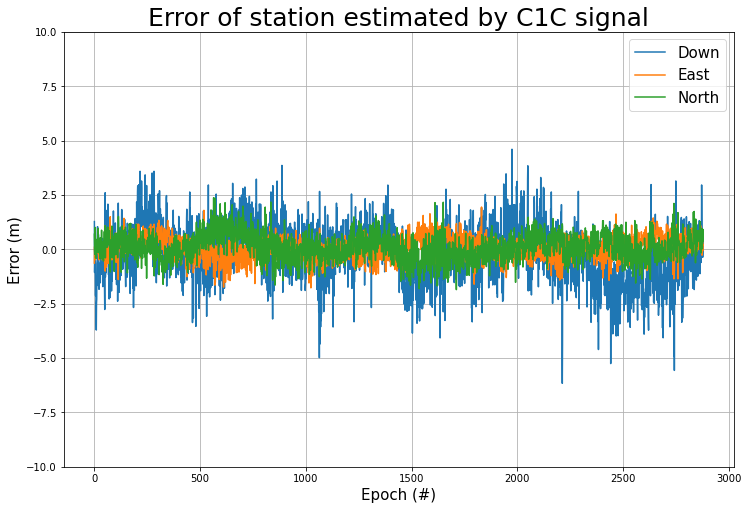

In [7]:
# Now we plot the error of every fix in NED (North, East, Down)
# coordinates, we see clearly that the Down axis is noisier, 
# this is to be expected as the VDOP is generally much larger
# than the HDOP.

conv = LocalCoord.from_ecef(slac_exact_position)
errors_ned = conv.ecef2ned(ests[:, :3])
figsize(12, 8)
plot(errors_ned[:, 2], label='Down');
plot(errors_ned[:, 1], label='East');
plot(errors_ned[:, 0], label='North');
title('Error of station estimated by C1C signal', fontsize=25);
ylim(-10, 10);
xlabel('Epoch (#)', fontsize=15);
ylabel('Error (m)', fontsize=15);
legend(fontsize=15);
grid();

# The error of the median position compared to the true
# position is ~0.5m with this technique. This is about what
# we would expect. Without using carrier phase measurements
# we do not expect better results.
print('The error of the median position is NED:')
print(np.median(errors_ned, axis=0))

In [8]:
# Out of curiosity we repeat the previous experiment, but we use
# the C2P signal. Just to make sure we get similar results. And while
# we're at it lets compare the residuals of GLONASS and GPS.
from laika.helpers import get_constellation

ests, errs, residuals_gps, residuals_glonass = [], [], [], []
for corr in tqdm(rinex_corr_grouped[:]):
    sol = raw.calc_pos_fix(corr, signal='C2P')
    residuals_gps.append(raw.pr_residual([c for c in corr if get_constellation(c.prn).name == 'GPS'], signal='C2P')(np.append(slac_exact_position, sol[0][3:])))
    residuals_glonass.append(raw.pr_residual([c for c in corr if get_constellation(c.prn).name == 'GLONASS'], signal='C2P')(np.append(slac_exact_position, sol[0][3:])))
    ests.append(sol[0])
ests = np.array(ests)
residuals_gps = np.concatenate(residuals_gps)
residuals_glonass = np.concatenate(residuals_glonass)

  0%|          | 0/2880 [00:00<?, ?it/s]

The error of the median position is NED:
[ 0.2601537  -0.00930768  0.03828997]


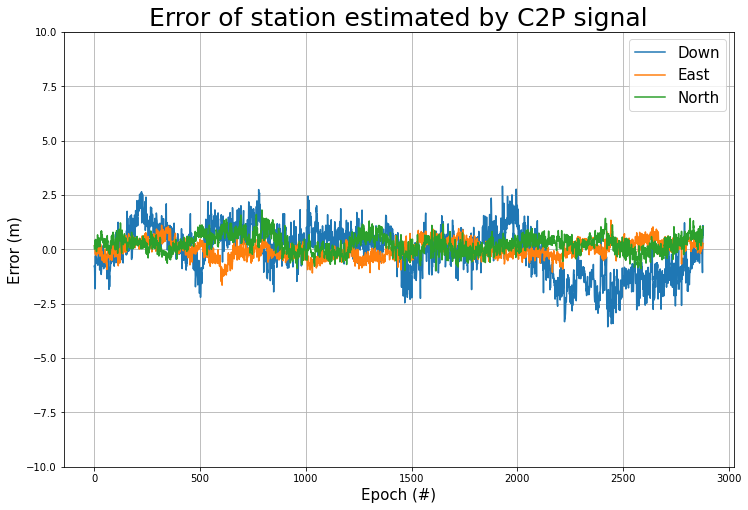

In [9]:
# We plot the error again and see similar results,
# this gives us confidence that the different signals
# are being processed correctly.

conv = LocalCoord.from_ecef(slac_exact_position)
errors_ned = conv.ecef2ned(ests[:, :3])
figsize(12, 8)
plot(errors_ned[:, 2], label='Down');
plot(errors_ned[:, 1], label='East');
plot(errors_ned[:, 0], label='North');
title('Error of station estimated by C2P signal', fontsize=25);
ylim(-10, 10);
xlabel('Epoch (#)', fontsize=15);
ylabel('Error (m)', fontsize=15);
legend(fontsize=15);
grid();

print('The error of the median position is NED:')
print(np.median(errors_ned, axis=0))

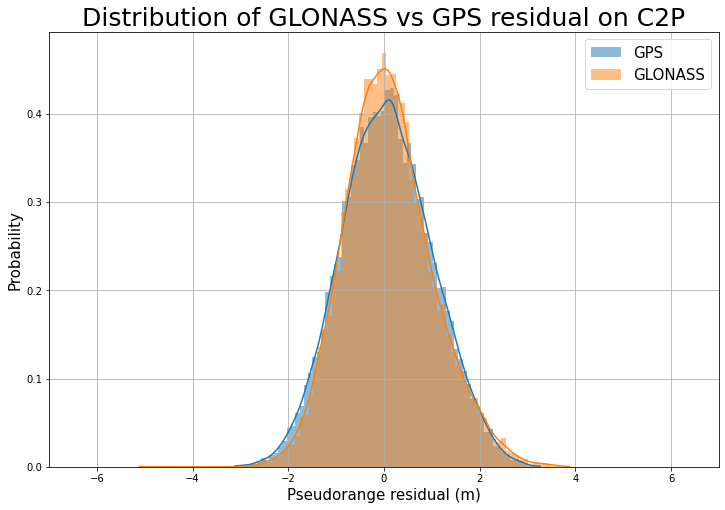

In [10]:
# When we look at the residual distributions of GLONASS
# and GPS here we see the distributions are very similar,
# showing that both constellations provide correct
# and good signal.

sns.histplot(residuals_gps[np.isfinite(residuals_gps)], label='GPS', color='C0', kde=True, stat="density", linewidth=0);
sns.histplot(residuals_glonass[np.isfinite(residuals_glonass)], label='GLONASS', color='C1', kde=True, stat="density", linewidth=0);
xlim(-7, 7);
xlabel('Pseudorange residual (m)', fontsize=15);
ylabel('Probability', fontsize=15);
title('Distribution of GLONASS vs GPS residual on C2P', fontsize=25);
grid();
legend(fontsize=15);